### Group Project 4 : Comparing 3 Models for Predicting Recidivism

For background on this project, please see the [README](../README.md).

**Notebooks**
- [Data Acquisition & Cleaning](./01_data_acq_clean.ipynb)
- Exploratory Data Analysis (this notebook)
- [Modeling](./03_modeling.ipynb)
- [Experiments](./03a_experiments.ipynb)
- [Results and Recommendations](./04_results.ipynb)

**In this notebook, you'll find (for each of the 3 datasets):**
- Descriptive statistics and distributions
- Baseline accuracy
- Visualizations of interesting columns (features and EDA-only)

In [137]:
# just need pandas and visualizations for this notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

---
**Model 1: Base feature set - New York**

In [138]:
# read in clean NY dataset and remind ourselves what it looks like
ny_df = pd.read_csv('../data/NY/NY_final.csv')
ny_df.head()

,Release Year,County of Indictment,Gender,Age at Release,Return Status,recidivism,gender_map
0,2008,UNKNOWN,MALE,55,Not Returned,0,1
1,2008,ALBANY,MALE,16,Returned Parole Violation,1,1
2,2008,ALBANY,MALE,17,Not Returned,0,1
3,2008,ALBANY,MALE,17,Returned Parole Violation,1,1
4,2008,ALBANY,MALE,18,Not Returned,0,1


In [139]:
# get some descriptive statistics
ny_df.describe()

,Release Year,Age at Release,recidivism,gender_map
count,188650.000000,188650.000000,188650.000000,188650.000000
mean,2011.326064,35.473400,0.416894,0.937228
std,2.289170,10.972873,0.493046,0.242554
min,2008.000000,16.000000,0.000000,0.000000
25%,2009.000000,26.000000,0.000000,1.000000
50%,2011.000000,34.000000,0.000000,1.000000
75%,2013.000000,44.000000,1.000000,1.000000
max,2015.000000,100.000000,1.000000,1.000000


- Based on a quick review of the stats we can see the average ages and distribution of ages at release,
  which mainly range between 26 and 44 years old.
- We can also see the data spans release years between 2008 and 2015.

##### Baseline accuracy

In [140]:
ny_df['Return Status'].value_counts(normalize = True)

Not Returned                 0.583106
Returned Parole Violation    0.325370
New Felony Offense           0.091524
Name: Return Status, dtype: float64

In [141]:
#Baseline Metrics for Model Evaluation:
ny_df['recidivism'].value_counts(normalize = True)

0    0.583106
1    0.416894
Name: recidivism, dtype: float64

CONCLUSIONS
- For modeling, we will combine returned parole violation and returned new felony, as these both represent recidivism.
- The majority class, Not Returned, represents **58%** of the observations, which will serve as the baseline model accuracy.

##### Age at Release

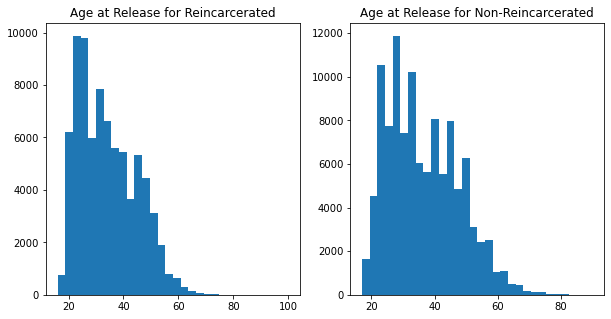

In [142]:
fig, ax = plt.subplots(1,2, figsize = (10, 5))

ax[0].hist(ny_df[ny_df['recidivism'] == 1]['Age at Release'], bins = 30)
ax[0].set_title('Age at Release for Reincarcerated')
ax[1].hist(ny_df[ny_df['recidivism'] == 0]['Age at Release'], bins = 30)
ax[1].set_title('Age at Release for Non-Reincarcerated');

CONCLUSIONS
- Distribution of the Age at Release is pretty similar between those who are reincarcerated and those who are not with reincarcerated, trending slightly lower in age.
- We'll try a bucketing strategy for further analysis.

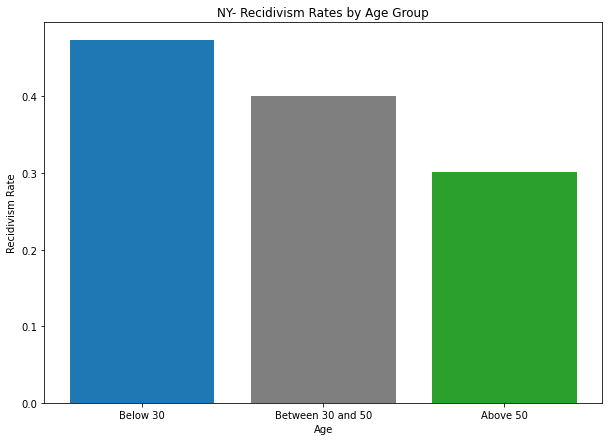

In [143]:
# split the dataset into different age ranges below 30, 30-50, 50 and above
below30 = ny_df[ny_df['Age at Release'] < 30]
between_30_50 = ny_df[(ny_df['Age at Release'] >= 30) & (ny_df['Age at Release'] <= 50)]
above50 = ny_df[ny_df['Age at Release'] > 50]

# calculate recidivism rate for each age group as recidivism = reincarcerated / total pop
below30_recid_rate = (below30[below30['recidivism'] == 1]['recidivism'].value_counts()) / below30.shape[0]
between_30_50_recid_rate = (between_30_50[between_30_50['recidivism'] == 1]['recidivism'].value_counts()) / between_30_50.shape[0]
above_50_recid_rate = (above50[above50['recidivism'] == 1]['recidivism'].value_counts()) / above50.shape[0]

# Here we can see a steady decline in recidivism rates as the age at release increases. 
plt.figure(figsize = (10, 7))
plt.bar(x = 'Below 30', height= below30_recid_rate, color = 'tab:blue')
plt.bar(x = 'Between 30 and 50', height = between_30_50_recid_rate, color = 'tab:gray')
plt.bar(x = 'Above 50', height = above_50_recid_rate, color = 'tab:green')
plt.xlabel('Age')
plt.ylabel('Recidivism Rate')
plt.title('NY- Recidivism Rates by Age Group');

CONCLUSIONS:
- There is a noticeable decline in recidivism as age increases.

##### Gender

In [144]:
male = ny_df[ny_df['Gender'] == 'MALE']
female = ny_df[ny_df['Gender'] == 'FEMALE']

In [145]:
# basic counts
print(f'Count of Female Observations: {female.shape[0]}')
print(f'Count of Male Observations: {male.shape[0]}')
ny_df['Gender'].value_counts(normalize = True)

Count of Female Observations: 11842
Count of Male Observations: 176808


MALE      0.937228
FEMALE    0.062772
Name: Gender, dtype: float64

- Males represent an overwhelming ~94% of the observations.
- As such, it may be difficult to draw accurate comparisons with only ~12k female observations v. 176k males.

In [146]:
# descriptive stats for males
male.describe() 

,Release Year,Age at Release,recidivism,gender_map
count,176808.000000,176808.000000,176808.000000,176808.0
mean,2011.327734,35.376476,0.425145,1.0
std,2.286653,11.000085,0.494366,0.0
min,2008.000000,16.000000,0.000000,1.0
25%,2009.000000,26.000000,0.000000,1.0
50%,2011.000000,33.000000,0.000000,1.0
75%,2013.000000,44.000000,1.000000,1.0
max,2015.000000,100.000000,1.000000,1.0


In [147]:
# descriptive stats for females
female.describe()

,Release Year,Age at Release,recidivism,gender_map
count,11842.000000,11842.000000,11842.000000,11842.0
mean,2011.301132,36.920537,0.293700,0.0
std,2.326383,10.452333,0.455476,0.0
min,2008.000000,17.000000,0.000000,0.0
25%,2009.000000,28.000000,0.000000,0.0
50%,2011.000000,36.000000,0.000000,0.0
75%,2013.000000,45.000000,1.000000,0.0
max,2015.000000,86.000000,1.000000,0.0


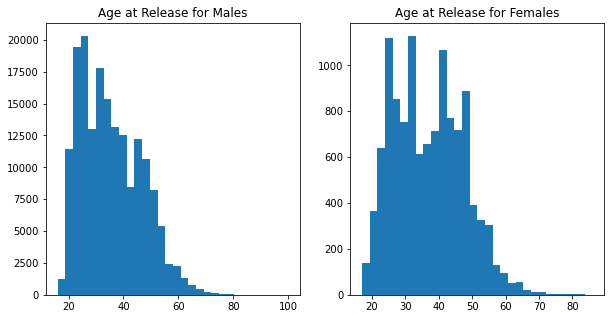

In [148]:
# compare histograms for gender groups
fig, ax = plt.subplots(1,2, figsize = (10, 5))

ax[0].hist(male['Age at Release'], bins = 30)
ax[0].set_title('Age at Release for Males')
ax[1].hist(female['Age at Release'], bins = 30)
ax[1].set_title('Age at Release for Females');

CONCLUSIONS:
- The distribution of age at release is slightly lower for men as opposed to women. 
- Avg age at release for women is 37 versus 35 for men.

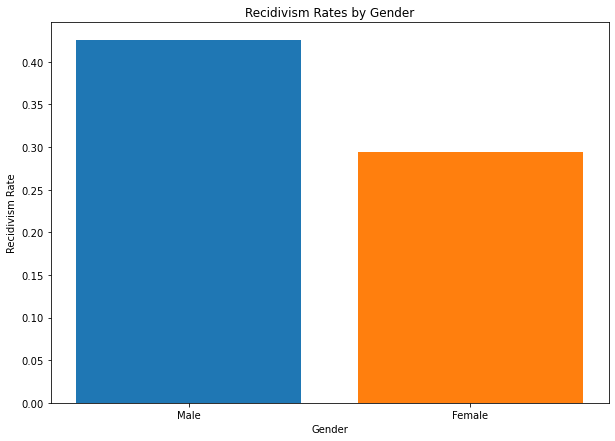

In [149]:
# direct comparison of recidivism between gender groups
plt.figure(figsize = (10, 7))
plt.bar(x = 'Male', height= male[male['recidivism'] == 1]['recidivism'].value_counts() / male.shape[0])
plt.bar(x = 'Female', height = female[female['recidivism'] == 1]['recidivism'].value_counts() / female.shape[0])
plt.xlabel('Gender')
plt.ylabel('Recidivism Rate')
plt.title('Recidivism Rates by Gender');

- Men have a 13% higher recidivism rate then women.

##### County of Indictment

In [150]:
# how many counties?
ny_df['County of Indictment'].nunique()

63

In [151]:
# check out the top 15 counties represented in dataset
county_stats = ny_df['County of Indictment'].value_counts(normalize = True)[:15]
print(county_stats)
print()
print(f'% represented by top 15: {county_stats.sum()}')

NEW YORK       0.182067
KINGS          0.104394
BRONX          0.094355
QUEENS         0.070167
SUFFOLK        0.049632
MONROE         0.045460
ERIE           0.043615
ONONDAGA       0.033485
NASSAU         0.031625
ALBANY         0.031248
WESTCHESTER    0.023393
ORANGE         0.023096
ONEIDA         0.018669
BROOME         0.015823
SCHENECTADY    0.014583
Name: County of Indictment, dtype: float64

% represented by top 15: 0.7816114497747152


CONCLUSIONS
- There are 63 different counties of indictment; however, ~80% of observations come from 15 counties.

In [152]:
# Recidivism Rates by County of Indictment (showing the top 15 recidivism rates per county)
ny_df.groupby(['County of Indictment'])['recidivism'].mean().sort_values(ascending = False)[:15]

County of Indictment
MONROE         0.525770
ERIE           0.505105
SCHENECTADY    0.504907
CHEMUNG        0.501913
BROOME         0.497822
TOMPKINS       0.497630
CHAUTAUQUA     0.491356
TIOGA          0.485043
RENSSELAER     0.483302
CORTLAND       0.482866
ULSTER         0.482848
ONONDAGA       0.481716
SENECA         0.477663
ALBANY         0.475997
OSWEGO         0.474727
Name: recidivism, dtype: float64

---
**Model 2: Criminal history feature set - Florida**

In [153]:
fl = pd.read_csv('../data/FL/FL_final.csv')
fl.head()

,person_id,num_incarcerations,comp_f_min_score,comp_f_min_decile,comp_f_max_score,comp_f_max_decile,comp_r_min_score,comp_r_min_decile,comp_r_max_score,comp_r_max_decile,...,age_at_last_arrest,juvenile_at_first_arrest,juvenile_at_first_incarceration,recidivism,charge_degree_count_INF,first_charge_degree_INF,last_charge_degree_INF,total_misdemeanor_charge_count,total_felony_charge_count,total_charge_count
0,1,2,13,1,13,1,-2.78,1,-2.78,1,...,66,0,0,0,0.0,0,0,1.0,1.0,2.0
1,3,2,25,6,25,6,-0.76,3,-0.76,3,...,31,0,0,0,0.0,0,0,0.0,4.0,4.0
2,4,5,26,7,26,7,-0.66,4,-0.66,4,...,24,0,0,1,5.0,0,0,12.0,7.0,24.0
3,7,1,19,3,19,3,-1.93,1,-1.93,1,...,42,0,0,0,0.0,0,0,1.0,0.0,1.0
4,8,4,30,8,30,8,-0.16,6,-0.16,6,...,41,0,0,1,1.0,0,0,7.0,21.0,29.0


In [154]:
# descriptive stats
fl.describe()

,person_id,num_incarcerations,comp_f_min_score,comp_f_min_decile,comp_f_max_score,comp_f_max_decile,comp_r_min_score,comp_r_min_decile,comp_r_max_score,comp_r_max_decile,...,age_at_last_arrest,juvenile_at_first_arrest,juvenile_at_first_incarceration,recidivism,charge_degree_count_INF,first_charge_degree_INF,last_charge_degree_INF,total_misdemeanor_charge_count,total_felony_charge_count,total_charge_count
count,10645.000000,10645.000000,10645.000000,10645.00000,10645.000000,10645.000000,10645.000000,10645.000000,10645.000000,10645.000000,...,10645.000000,10645.000000,10645.000000,10645.000000,10645.000000,10645.000000,10645.000000,10645.000000,10645.000000,10645.000000
mean,5871.627900,2.468107,18.121465,2.99737,18.253828,3.052607,-0.743501,4.404227,-0.731223,4.452325,...,32.877689,0.024519,0.011930,0.392673,1.502771,0.038422,0.026397,3.667356,3.319399,8.489526
std,3398.077689,2.166900,5.600202,2.38493,5.662433,2.410957,0.857946,2.868724,0.863261,2.891061,...,11.828343,0.154660,0.108578,0.488368,3.023849,0.192221,0.160321,4.583120,4.635432,10.422754
min,1.000000,1.000000,11.000000,1.00000,11.000000,1.000000,-3.210000,-1.000000,-3.210000,-1.000000,...,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2921.000000,1.000000,14.000000,1.00000,14.000000,1.000000,-1.340000,2.000000,-1.330000,2.000000,...,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000
50%,5866.000000,2.000000,17.000000,2.00000,17.000000,2.000000,-0.710000,4.000000,-0.690000,4.000000,...,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,5.000000
75%,8813.000000,3.000000,21.000000,4.00000,21.000000,4.000000,-0.120000,7.000000,-0.100000,7.000000,...,41.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,5.000000,4.000000,11.000000
max,11757.000000,28.000000,50.000000,10.00000,50.000000,10.000000,2.360000,10.000000,2.360000,10.000000,...,95.000000,1.000000,1.000000,1.000000,104.000000,1.000000,1.000000,46.000000,58.000000,152.000000


CONCLUSIONS
- Gabe TODO

##### Baseline

In [155]:
#Baseline Metrics for Model Evaluation:
fl['recidivism'].value_counts(normalize = True)

0    0.607327
1    0.392673
Name: recidivism, dtype: float64

CONCLUSIONS:
- The target classes are about 60-40, which is not a severe imbalance, but possibly worth mitigating during modeling.
- Our baseline accuracy for this model, represented by the non-recidivist measure (value = 0), is about **61%**.

##### Recidivism by age group at first incarceration & first release

We will employ a "bucketing" strategy here, similar to the analysis for the NY dataset.

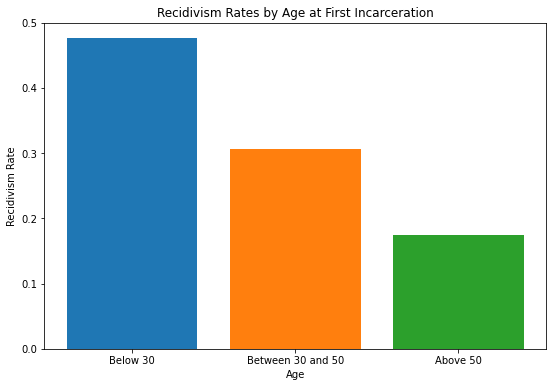

In [156]:
# Taking a look at recidivism by age at first incarceration
#split the dataset into different age ranges below 30, 30-50, 50 and above
below30 = fl[fl['age_at_first_incarceration'] < 30]
between_30_50 = fl[(fl['age_at_first_incarceration'] >= 30) & (fl['age_at_first_incarceration'] <= 50)]
above50 = fl[fl['age_at_first_incarceration'] > 50]

#calculate recidivism rate for each age group as recidivism = reincarcerated / total pop
below30_recid_rate = (below30[below30['recidivism'] == 1]['recidivism'].value_counts()) / below30.shape[0]
between_30_50_recid_rate = (between_30_50[between_30_50['recidivism'] == 1]['recidivism'].value_counts()) / between_30_50.shape[0]
above_50_recid_rate = (above50[above50['recidivism'] == 1]['recidivism'].value_counts()) / above50.shape[0]

#Here we can see a steady decline in recidivism rates as the age at release increases. 
plt.figure(figsize = (9, 6))
plt.bar(x = 'Below 30', height= below30_recid_rate)
plt.bar(x = 'Between 30 and 50', height = between_30_50_recid_rate)
plt.bar(x = 'Above 50', height = above_50_recid_rate)
plt.xlabel('Age')
plt.ylabel('Recidivism Rate')
plt.title('Recidivism Rates by Age at First Incarceration');

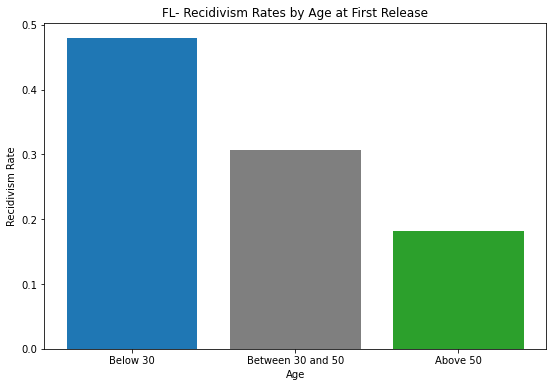

In [157]:
# Taking a look at recidivism by age at release from first incarceration
# split the dataset into different age ranges below 30, 30-50, 50 and above
below30 = fl[fl['age_at_first_release'] < 30]
between_30_50 = fl[(fl['age_at_first_release'] >= 30) & (fl['age_at_first_release'] <= 50)]
above50 = fl[fl['age_at_first_release'] > 50]

# calculate recidivism rate for each age group as recidivism = reincarcerated / total pop
below30_recid_rate = (below30[below30['recidivism'] == 1]['recidivism'].value_counts()) / below30.shape[0]
between_30_50_recid_rate = (between_30_50[between_30_50['recidivism'] == 1]['recidivism'].value_counts()) / between_30_50.shape[0]
above_50_recid_rate = (above50[above50['recidivism'] == 1]['recidivism'].value_counts()) / above50.shape[0]

# Here we can see a steady decline in recidivism rates as the age at release increases. 
plt.figure(figsize = (9, 6))
plt.bar(x = 'Below 30', height= below30_recid_rate, color = 'tab:blue')
plt.bar(x = 'Between 30 and 50', height = between_30_50_recid_rate, color = 'tab:gray')
plt.bar(x = 'Above 50', height = above_50_recid_rate, color = 'tab:green')
plt.xlabel('Age')
plt.ylabel('Recidivism Rate')
plt.title('FL- Recidivism Rates by Age at First Release');

CONCLUSIONS:
- Very similar to what we saw in the NY data - as age increases, the recidivism rates drop significantly, regardless of whether
  age is measured at inception or completion of first incarceration.

##### Recidivism by gender

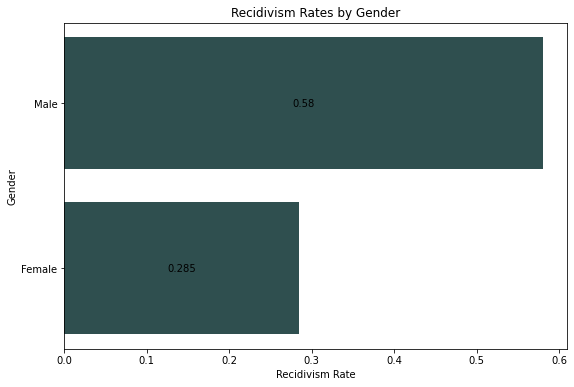

In [158]:
gender_recidivism = fl.groupby(by = ['sex_Male'])['recidivism'].value_counts(normalize=True)
gender_recidivism = pd.DataFrame(gender_recidivism)

fig, ax = plt.subplots(figsize = (9, 6))

y_vals = [val for val, bool in gender_recidivism.index[::2]]
recid_pcts = [round(val, 3) for val in gender_recidivism['recidivism'][1:3]]
gender_plot = ax.barh(y=y_vals, 
    width=recid_pcts, color='darkslategray')
ax.bar_label(gender_plot, label_type='center')
ax.set(title='Recidivism Rates by Gender', xlabel='Recidivism Rate', ylabel='Gender', yticks=[0, 1], yticklabels=['Female', 'Male'])
plt.show();

CONCLUSIONS
- As we saw earlier, male recidivists outnumber female recidivists significantly.

##### Distribution of lifetime-first charge degrees

In [159]:
first_charge_degree_cols = [col for col in fl if col.startswith('first_charge_degree')]

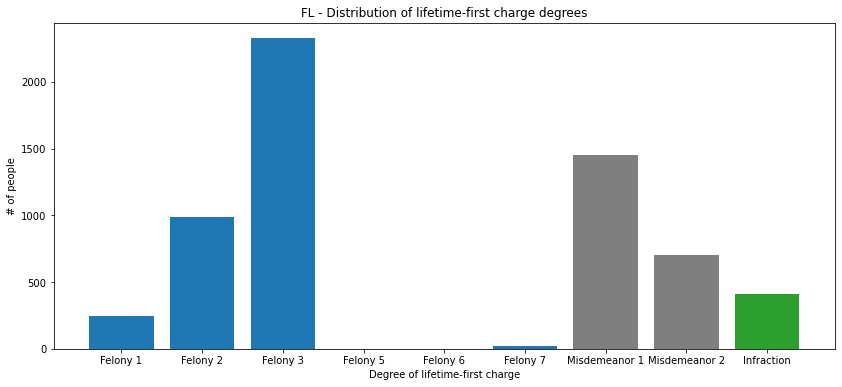

In [160]:
plt.figure(figsize = (14, 6))
plt.bar(x = 'Felony 1', height = fl['first_charge_degree_F1'].sum(), color = 'tab:blue')
plt.bar(x = 'Felony 2', height = fl['first_charge_degree_F2'].sum(), color = 'tab:blue')
plt.bar(x = 'Felony 3', height = fl['first_charge_degree_F3'].sum(), color = 'tab:blue')
plt.bar(x = 'Felony 5', height = fl['first_charge_degree_F5'].sum(), color = 'tab:blue')
plt.bar(x = 'Felony 6', height = fl['first_charge_degree_F6'].sum(), color = 'tab:blue')
plt.bar(x = 'Felony 7', height = fl['first_charge_degree_F7'].sum(), color = 'tab:blue')
plt.bar(x = 'Misdemeanor 1', height = fl['first_charge_degree_M1'].sum(), color = 'tab:gray')
plt.bar(x = 'Misdemeanor 2', height = fl['first_charge_degree_M2'].sum(), color = 'tab:gray')
plt.bar(x = 'Infraction', height = fl['first_charge_degree_INF'].sum(), color = 'tab:green')
plt.xlabel('Degree of lifetime-first charge')
plt.ylabel('# of people')
plt.title('FL - Distribution of lifetime-first charge degrees');

##### Distribution of lifetime charge counts

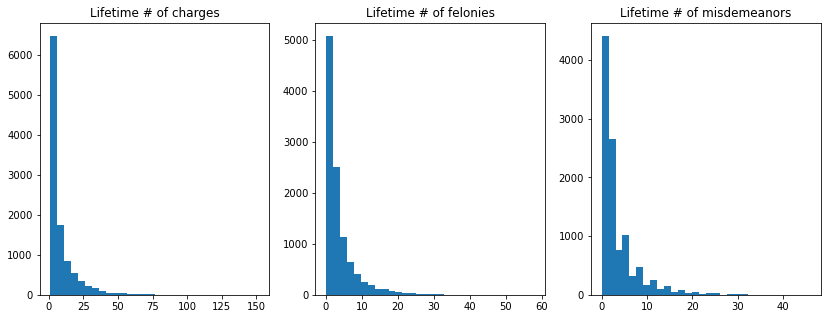

In [161]:
fig, ax = plt.subplots(1, 3, figsize = (14, 5))

ax[0].hist(fl['total_charge_count'], bins = 30)
ax[0].set_title('Lifetime # of charges')
ax[1].hist(fl['total_felony_charge_count'], bins = 30)
ax[1].set_title('Lifetime # of felonies')
ax[2].hist(fl['total_misdemeanor_charge_count'], bins = 30)
ax[2].set_title('Lifetime # of misdemeanors');

In [162]:
fl.columns

Index(['person_id', 'num_incarcerations', 'comp_f_min_score',
       'comp_f_min_decile', 'comp_f_max_score', 'comp_f_max_decile',
       'comp_r_min_score', 'comp_r_min_decile', 'comp_r_max_score',
       'comp_r_max_decile', 'comp_v_min_score', 'comp_v_min_decile',
       'comp_v_max_score', 'comp_v_max_decile', 'sex_Male', 'race_Asian',
       'race_Caucasian', 'race_Hispanic', 'race_Native American', 'race_Other',
       'charge_degree_count_F1', 'charge_degree_count_F2',
       'charge_degree_count_F3', 'charge_degree_count_F5',
       'charge_degree_count_F6', 'charge_degree_count_F7',
       'charge_degree_count_M1', 'charge_degree_count_M2',
       'charge_degree_count_M3', 'agg_charges', 'avg_days_between_offenses',
       'avg_days_between_arrests', 'first_charge_degree_F1',
       'first_charge_degree_F2', 'first_charge_degree_F3',
       'first_charge_degree_F5', 'first_charge_degree_F6',
       'first_charge_degree_F7', 'first_charge_degree_M1',
       'first_charge_degree

In [163]:
corr_cols = ['avg_days_between_offenses', 'avg_days_between_arrests',
'age_at_first_arrest', 'age_at_last_arrest',
       'age_at_first_incarceration',  'age_at_last_incarceration',
       'age_at_first_release', 'age_at_last_release',
       'total_misdemeanor_charge_count',
       'total_felony_charge_count', 'total_charge_count', 'recidivism']
fl_corr = fl[corr_cols].corr()
fl_corr

,avg_days_between_offenses,avg_days_between_arrests,age_at_first_arrest,age_at_last_arrest,age_at_first_incarceration,age_at_last_incarceration,age_at_first_release,age_at_last_release,total_misdemeanor_charge_count,total_felony_charge_count,total_charge_count,recidivism
avg_days_between_offenses,1.000000,0.549800,0.204754,0.011872,0.077285,0.014135,0.069042,0.012021,-0.264318,-0.241554,-0.277197,-0.319178
avg_days_between_arrests,0.549800,1.000000,0.335092,-0.008400,0.114952,-0.007474,0.096964,-0.012283,-0.465861,-0.429784,-0.488367,-0.597662
age_at_first_arrest,0.204754,0.335092,1.000000,0.799832,0.858197,0.796390,0.853518,0.793496,-0.244858,-0.275501,-0.271731,-0.223363
age_at_last_arrest,0.011872,-0.008400,0.799832,1.000000,0.885468,0.993903,0.893064,0.993935,0.088896,0.132466,0.128820,0.002151
age_at_first_incarceration,0.077285,0.114952,0.858197,0.885468,1.000000,0.888199,0.994430,0.885539,-0.095932,-0.144144,-0.110530,-0.228302
age_at_last_incarceration,0.014135,-0.007474,0.796390,0.993903,0.888199,1.000000,0.895874,0.999342,0.085052,0.127943,0.124999,-0.008826
age_at_first_release,0.069042,0.096964,0.853518,0.893064,0.994430,0.895874,1.000000,0.894301,-0.081697,-0.115409,-0.089134,-0.221007
age_at_last_release,0.012021,-0.012283,0.793496,0.993935,0.885539,0.999342,0.894301,1.000000,0.088416,0.135112,0.130050,-0.004963
total_misdemeanor_charge_count,-0.264318,-0.465861,-0.244858,0.088896,-0.095932,0.085052,-0.081697,0.088416,1.000000,0.643575,0.916832,0.435254
total_felony_charge_count,-0.241554,-0.429784,-0.275501,0.132466,-0.144144,0.127943,-0.115409,0.135112,0.643575,1.000000,0.845881,0.410565


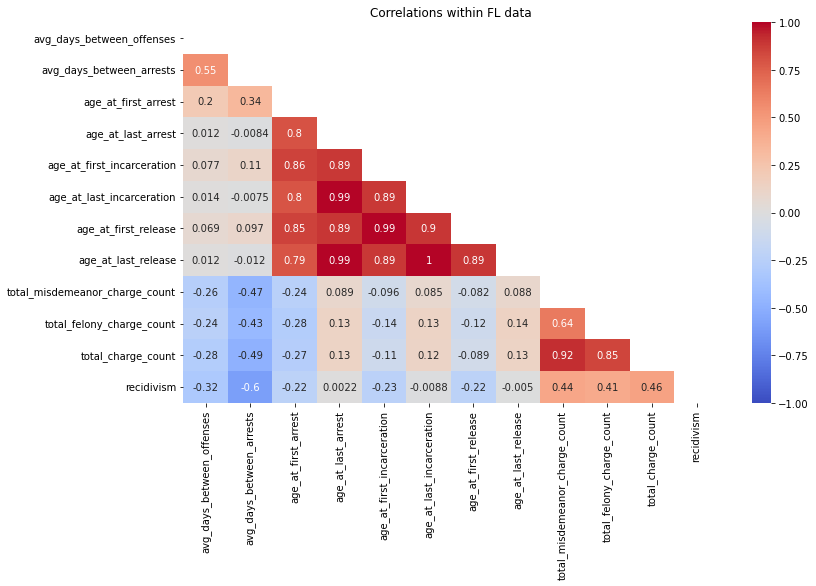

In [164]:
# let's see if there are any interesting correlations

plt.figure(figsize = (12, 7))
mask = np.zeros_like(fl_corr)
mask[np.triu_indices_from(mask)] = True
plt.title('Correlations within FL data')
hm = sns.heatmap(fl_corr, vmin = -1, vmax = 1, cmap = 'coolwarm', annot = True, mask = mask);

#### Investigating COMPAS scores

Below, we split the compass risk scores (recidivism 'r', violence 'v', and _'f') into decile groups based on their risk score. We then plot the recidivism rates for each decile group to evaluate the accuracy of these scores.

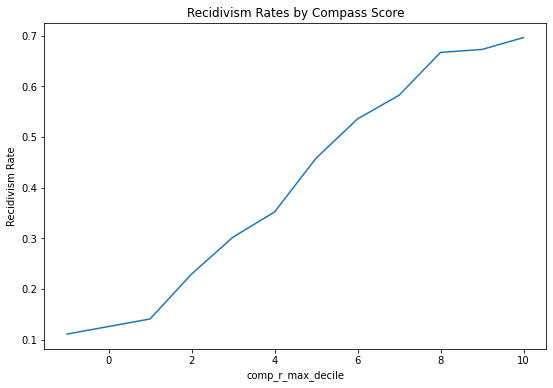

In [79]:
plt.figure(figsize = (9, 6))
fl.groupby(['comp_r_max_decile'])['recidivism'].mean().sort_values(ascending = False).plot()
plt.ylabel('Recidivism Rate')
plt.title('Recidivism Rates by Compass Score');

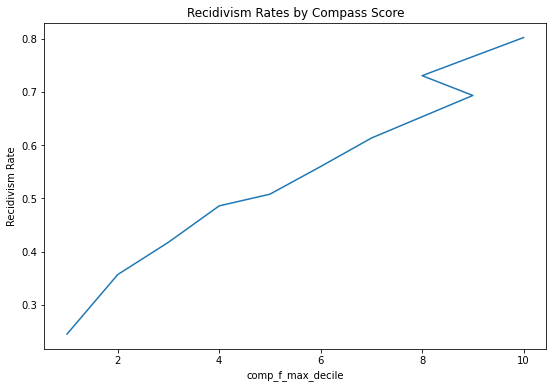

In [80]:
plt.figure(figsize = (9, 6))
fl.groupby(['comp_f_max_decile'])['recidivism'].mean().sort_values(ascending = False).plot()
plt.ylabel('Recidivism Rate')
plt.title('Recidivism Rates by Compass Score');

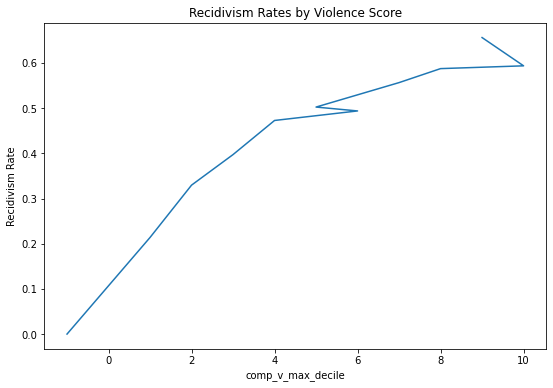

In [81]:
plt.figure(figsize = (9, 6))
fl.groupby(['comp_v_max_decile'])['recidivism'].mean().sort_values(ascending = False).plot()
plt.ylabel('Recidivism Rate')
plt.title('Recidivism Rates by Violence Score');

CONCLUSIONS:
- There is a clear upward trend across all risk scores, showing that those rate with higher risk scores are re-offending at higher rates.

**Model 3: Behavioral feature set - Georgia**

In [82]:
# Reading in the cleaned data

ga = pd.read_csv('../data/GA/GA_final.csv')
ga.drop(columns = 'Unnamed: 0', inplace=True)
ga.head()

,gender_male,age_at_release,gang_affiliated,supervision_risk_score_first,education_level,dependents,prison_years,prior_arrest_episodes_felony,prior_arrest_episodes_misd,prior_arrest_episodes_violent,...,delinquency_reports,program_attendances,residence_changes,avg_days_per_drugtest,drugtests_thc_positive,drugtests_cocaine_positive,drugtests_meth_positive,drugtests_other_positive,percent_days_employed,recidivism_within_3years
0,1,43-47,0,3.0,at least some college,3,more than 3 years,6,6,1,...,0,6,2,612.000000,0.000000,0.0,0.000000,0.0,0.488562,0
1,1,33-37,0,6.0,less than hs diploma,1,more than 3 years,7,6,3,...,4,0,2,35.666667,0.000000,0.0,0.000000,0.0,0.425234,1
2,1,48 or older,0,7.0,at least some college,3,1-2 years,6,6,3,...,4,6,0,93.666667,0.333333,0.0,0.166667,0.0,0.000000,1
3,1,38-42,0,7.0,less than hs diploma,1,1-2 years,8,6,0,...,0,6,3,25.400000,0.000000,0.0,0.000000,0.0,1.000000,0
4,1,33-37,0,4.0,less than hs diploma,3,1-2 years,4,4,3,...,0,7,0,23.117647,0.000000,0.0,0.058824,0.0,0.203562,1


### Are certain demographic classes more likely to be reincarcerated?

#### Age

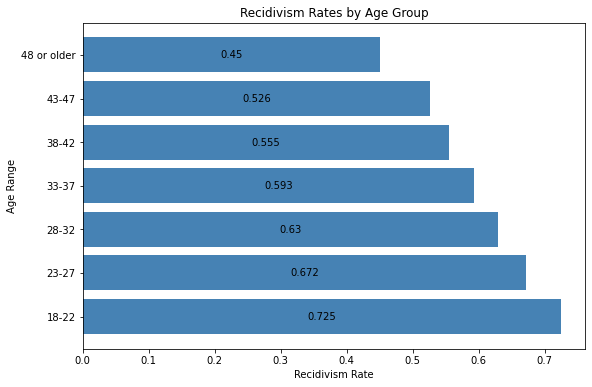

In [83]:
age_recidivism = ga.groupby(by = ['age_at_release'])['recidivism_within_3years'].value_counts(normalize=True)
age_recidivism = pd.DataFrame(age_recidivism)

fig, ax = plt.subplots(figsize=(9, 6))

y_vals = [val for val, bool in age_recidivism.index[::2]]
recid_pcts = [round(val,3) for val in age_recidivism['recidivism_within_3years'][0:-2][::2]]
recid_pcts.append(round(age_recidivism['recidivism_within_3years'][-2:][1], 3))
age_plot = ax.barh(y=y_vals, 
    width=recid_pcts, color='steelblue')
ax.bar_label(age_plot, label_type='center')
ax.set(title='Recidivism Rates by Age Group', xlabel='Recidivism Rate', ylabel='Age Range')
plt.show();

We can see a clear pattern here of those in the younger age groups being more likely to recidivate than those in the older groups. The lowest rate is among those in the 48 or older age range, and the highest rate of more than 72% is seen in 18-22 year olds.

#### Gender

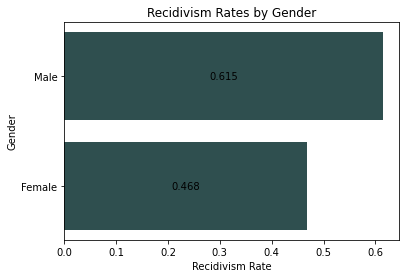

In [84]:
gender_recidivism = ga.groupby(by = ['gender_male'])['recidivism_within_3years'].value_counts(normalize=True)
gender_recidivism = pd.DataFrame(gender_recidivism)

fig, ax = plt.subplots()

y_vals = [val for val, bool in gender_recidivism.index[::2]]
recid_pcts = [round(val, 3) for val in gender_recidivism['recidivism_within_3years'][1:3]]
gender_plot = ax.barh(y=y_vals, 
    width=recid_pcts, color='darkslategray')
ax.bar_label(gender_plot, label_type='center')
ax.set(title='Recidivism Rates by Gender', xlabel='Recidivism Rate', ylabel='Gender', yticks=[0, 1], yticklabels=['Female', 'Male'])
plt.show();

Holding all else equal, men are about 15% more likely to be reincarcerated than women.

#### Number of Dependents

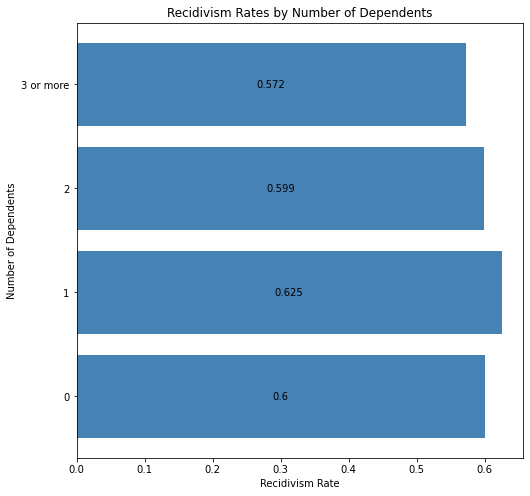

In [85]:
dpndts_recidivism = ga.groupby(by = ['dependents'])['recidivism_within_3years'].value_counts(normalize=True)
dpndts_recidivism = pd.DataFrame(dpndts_recidivism)

fig, ax = plt.subplots(figsize = (8,8))

y_vals = [val for val, bool in dpndts_recidivism.index[::2]]
recid_pcts = [round(val, 3) for val in dpndts_recidivism['recidivism_within_3years'][::2]]
dpndts_plot = ax.barh(y=y_vals, 
    width=recid_pcts, color='steelblue')
ax.bar_label(dpndts_plot, label_type='center')
ax.set(title='Recidivism Rates by Number of Dependents', xlabel='Recidivism Rate', ylabel='Number of Dependents', yticks=[0, 1, 2, 3], yticklabels=[0, 1, 2, '3 or more'])
plt.show();

The recidivism rates appear to be evenly distributed and not highly correlated with any number of dependents.

#### Education Level

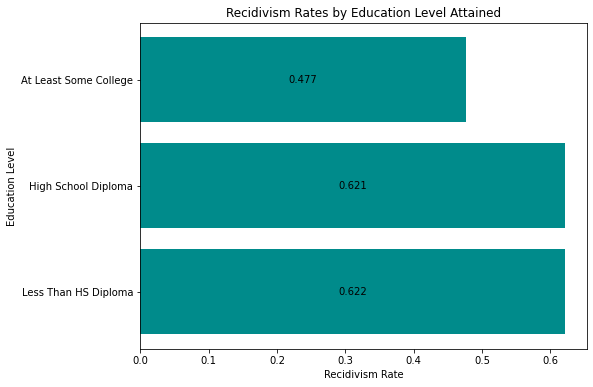

In [86]:
education_recidivism = ga.groupby(by = ['education_level'])['recidivism_within_3years'].value_counts(normalize=True)
education_recidivism = pd.DataFrame(education_recidivism)

fig, ax = plt.subplots(figsize=(8, 6))

y_vals = [val for val, bool in education_recidivism.index[::2]]
recid_pcts = [round(val,3) for val in education_recidivism['recidivism_within_3years'][1:3]]
recid_pcts.append(round(education_recidivism['recidivism_within_3years'][4], 3))
edu_plot = ax.barh(y=y_vals[::-1], 
    width=recid_pcts[::-1], color='darkcyan')
ax.bar_label(edu_plot, label_type='center')
ax.set(title='Recidivism Rates by Education Level Attained', xlabel='Recidivism Rate', ylabel='Education Level', yticks=[0, 1, 2], yticklabels=['Less Than HS Diploma', 'High School Diploma', 'At Least Some College'])
plt.show();

We can see here that the lowest recidivism rate is seen in those that have at least some college experience. Those who did not graduate from high school and those who do not have any education beyond a high school diploma have similar recidivism rates of about 62%. 

*Note: These education levels are what had been achieved upon prison entry.*

#### Gang Affiliation

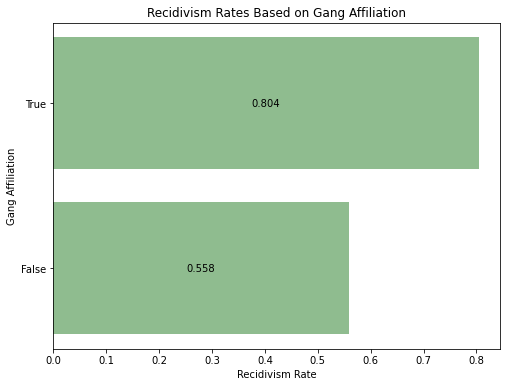

In [87]:
gang_recidivism = ga.groupby(by = ['gang_affiliated'])['recidivism_within_3years'].value_counts(normalize=True)
gang_recidivism = pd.DataFrame(gang_recidivism)

fig, ax = plt.subplots(figsize=(8,6))

y_vals = [val for val, bool in gang_recidivism.index[::2]]
recid_pcts = [round(val,3) for val in gang_recidivism['recidivism_within_3years'][::2]]
gang_plot = ax.barh(y=y_vals, 
    width=recid_pcts, color='darkseagreen')
ax.bar_label(gang_plot, label_type='center')
ax.set(title='Recidivism Rates Based on Gang Affiliation', xlabel='Recidivism Rate', ylabel='Gang Affiliation', yticks=[0, 1], yticklabels=['False', 'True'])
plt.show();

There appears to be a clear trend here that those who have been confirmed as gang-affiliated are more likely to recidivate than those who are not.

### Do previous prison or parole experiences indicate a higher likelihood of recidivism?

#### Time Spent in Prison Prior to Most Recent Arrest

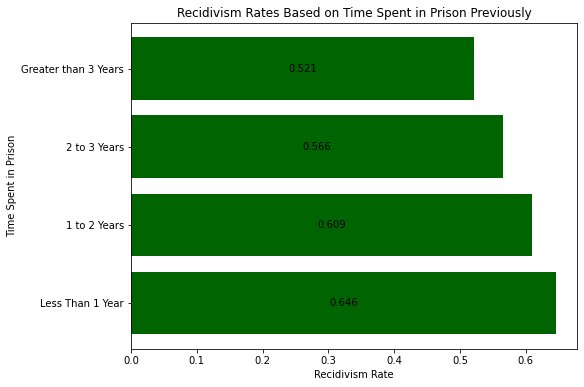

In [88]:
prison_years_recidivism = ga.groupby(by = ['prison_years'])['recidivism_within_3years'].value_counts(normalize=True)
prison_years_recidivism = pd.DataFrame(prison_years_recidivism)

prison_years_df = prison_years_recidivism.reset_index(drop=True)
prison_years_df['prison_time'] = ['1-2 years', '1-2 years', 'greater than 2 to 3 years', 'greater than 2 to 3 years', 'less than 1 year', 'less than 1 year', 'more than 3 years', 'more than 3 years']
prison_years_sorted = prison_years_df[::2].sort_values(by='recidivism_within_3years')

fig, ax = plt.subplots(figsize=(8,6))

y_vals = [val for val in prison_years_sorted['prison_time']]
recid_pcts = [round(val,3) for val in prison_years_sorted['recidivism_within_3years']]
py_plot = ax.barh(y=y_vals[::-1], 
    width=recid_pcts[::-1], color='darkgreen')
ax.bar_label(py_plot, label_type='center')
ax.set(title='Recidivism Rates Based on Time Spent in Prison Previously', xlabel='Recidivism Rate', ylabel='Time Spent in Prison', yticks=[0, 1, 2, 3], yticklabels=['Less Than 1 Year', '1 to 2 Years', '2 to 3 Years', 'Greater than 3 Years'])
plt.show();

Interestingly, those who spent less time in prison previously are more likely to recidivate compared to those that spent a longer amount of time in prison before being released.

#### First Parole Supervision Risk Assessment Score

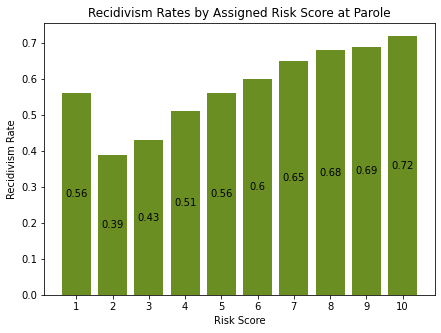

In [89]:
risk_score_recidivism = ga.groupby(by = ['supervision_risk_score_first'])['recidivism_within_3years'].value_counts(normalize=True)
risk_score_recidivism = pd.DataFrame(risk_score_recidivism)
risk_range = list(range(1,11))

fig, ax = plt.subplots(figsize=(7,5))

x_vals = [val for val, bool in risk_score_recidivism.index[::2]]
recid_pcts = [round(risk_score_recidivism['recidivism_within_3years'][1][1], 2)]
recid_pcts.extend(list(round(risk_score_recidivism['recidivism_within_3years'][3:6][::2],2)))
recid_pcts.extend([round(val,2) for val in risk_score_recidivism['recidivism_within_3years'][6:][::2]])
risk_plot = ax.bar(x=x_vals, 
    height=recid_pcts, color='olivedrab')
ax.bar_label(risk_plot, label_type='center')
ax.set(title='Recidivism Rates by Assigned Risk Score at Parole', xlabel='Risk Score', ylabel='Recidivism Rate', xticks=risk_range, xticklabels=risk_range)
plt.show();

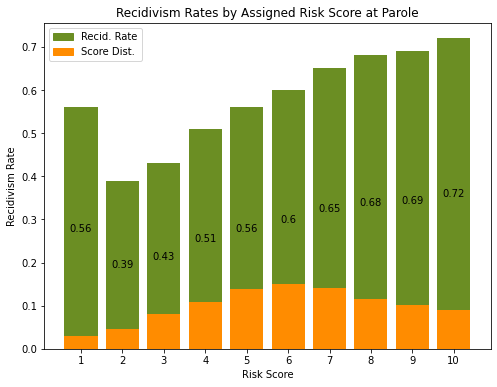

In [90]:
# Showing the same plot, including the distribution of risk scores given

risk_score_recidivism = ga.groupby(by = ['supervision_risk_score_first'])['recidivism_within_3years'].value_counts(normalize=True)
risk_score_recidivism = pd.DataFrame(risk_score_recidivism)
risk_range = list(range(1,11))

fig, ax = plt.subplots(figsize=(8,6))

x_vals = [val for val, bool in risk_score_recidivism.index[::2]]
recid_pcts = [round(risk_score_recidivism['recidivism_within_3years'][1][1], 2)]
recid_pcts.extend(list(round(risk_score_recidivism['recidivism_within_3years'][3:6][::2],2)))
recid_pcts.extend([round(val,2) for val in risk_score_recidivism['recidivism_within_3years'][6:][::2]])
risk_plot = ax.bar(x=x_vals, 
    height=recid_pcts, color='olivedrab')
ax.bar_label(risk_plot, label_type='center')
ax.set(title='Recidivism Rates by Assigned Risk Score at Parole', xlabel='Risk Score', ylabel='Recidivism Rate', xticks=risk_range, xticklabels=risk_range)
ax.bar(height= ga['supervision_risk_score_first'].value_counts(normalize=True).sort_index(axis=0), x=risk_range, color='darkorange')
recid_rates = mpatches.Patch(color='olivedrab', label='Recid. Rate')
risk_score_pcts = mpatches.Patch(color='darkorange', label='Score Dist.')
plt.legend(handles=[recid_rates, risk_score_pcts])
plt.show();

Based on the above, it appears that the scorers who are evaluating the individuals' risk at parole are mostly correct for scores 2 through 10. There is a discrepancy when a score of 1 is given, in that the risk level is perceived as low but more than half of these individuals did end up being rearrested.

#### Prior Arrest Episodes

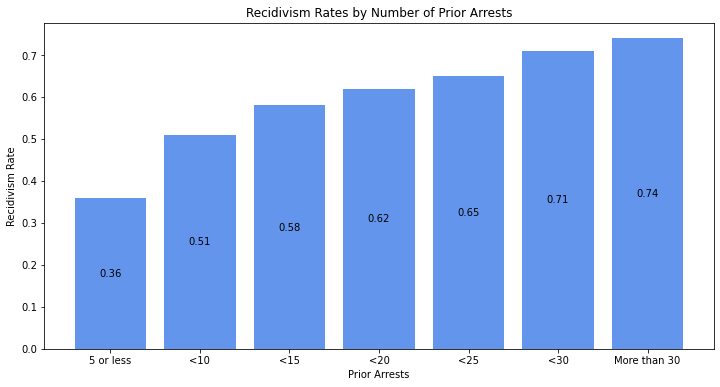

In [91]:
# Adding column to sum all prior arrests
prior_arrest_cols = [col for col in ga if col.startswith('prior_arrest')]
ga['prior_arrests_total'] = ga[prior_arrest_cols].iloc[:, :-2].sum(axis=1)

# Now adding a column here so that we're able to categorize the individual values within the prior_arrests_total column, and thus, better summarize the data

ga['prior_arrests_total_categ'] = pd.cut(ga['prior_arrests_total'], bins=7, labels=['5 or less', '<10', '<15', '<20', '<25', '<30', 'More than 30'])

arrests_recidivism = ga.groupby(by = ['prior_arrests_total_categ'])['recidivism_within_3years'].value_counts(normalize=True)
arrests_recidivism = pd.DataFrame(arrests_recidivism)

fig, ax = plt.subplots(figsize=(12,6))

x_vals = [val for val, bool in arrests_recidivism.index[::2]]
recid_pcts = [round(arrests_recidivism['recidivism_within_3years'][1], 2)]
recid_pcts.extend([round(val,2) for val in arrests_recidivism['recidivism_within_3years'][2:-1][::2]])
arrest_plot = ax.bar(x=x_vals, height=recid_pcts, color='cornflowerblue')
ax.bar_label(arrest_plot, label_type='center')
ax.set(title='Recidivism Rates by Number of Prior Arrests', xlabel='Prior Arrests', ylabel='Recidivism Rate')
plt.show();

Based on the above, we could reasonably conclude that the more times an individual has been arrested in the past, the more likely they are to be arrested again.

#### Drug Use

#### Parole Violations

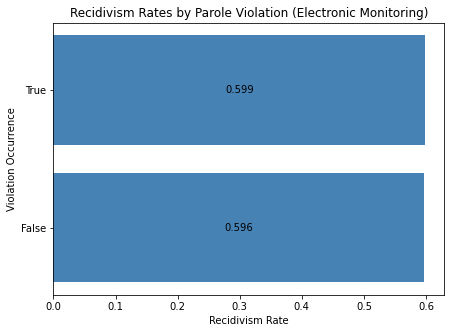

In [92]:
elecmonit_paroleviol_recidivism = ga.groupby(by = ['violations_electronicmonitoring'])['recidivism_within_3years'].value_counts(normalize=True)
elecmonit_paroleviol_recidivism = pd.DataFrame(elecmonit_paroleviol_recidivism)

fig, ax = plt.subplots(figsize=(7,5))

y_vals = [val for val in elecmonit_paroleviol_recidivism.index[0]]
recid_pcts = [round(val,3) for val in elecmonit_paroleviol_recidivism['recidivism_within_3years']]
em_pv_plot = ax.barh(y=y_vals, 
    width=recid_pcts[::2], color='steelblue')
ax.bar_label(em_pv_plot, label_type='center')
ax.set(title='Recidivism Rates by Parole Violation (Electronic Monitoring)', yticks=[0, 1], yticklabels=['False', 'True'], xlabel='Recidivism Rate', ylabel='Violation Occurrence')
plt.show();

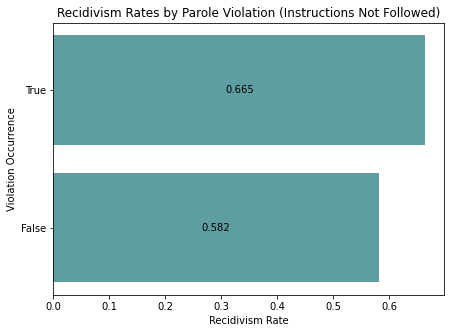

In [93]:
instruction_paroleviol_recidivism = ga.groupby(by = ['violations_instruction'])['recidivism_within_3years'].value_counts(normalize=True)
instruction_paroleviol_recidivism = pd.DataFrame(instruction_paroleviol_recidivism)

fig, ax = plt.subplots(figsize=(7,5))

y_vals = [val for val in instruction_paroleviol_recidivism.index[0]]
recid_pcts = [round(val,3) for val in instruction_paroleviol_recidivism['recidivism_within_3years']]
instr_pv_plot = ax.barh(y=y_vals, 
    width=recid_pcts[::2], color='cadetblue')
ax.bar_label(instr_pv_plot, label_type='center')
ax.set(title='Recidivism Rates by Parole Violation (Instructions Not Followed)', yticks=[0, 1], yticklabels=['False', 'True'], xlabel='Recidivism Rate', ylabel='Violation Occurrence')
plt.show();

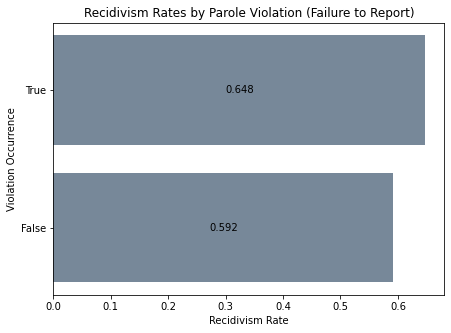

In [94]:
failtoreport_paroleviol_recidivism = ga.groupby(by = ['violations_failtoreport'])['recidivism_within_3years'].value_counts(normalize=True)
failtoreport_paroleviol_recidivism = pd.DataFrame(failtoreport_paroleviol_recidivism)

fig, ax = plt.subplots(figsize=(7,5))

y_vals = [val for val in failtoreport_paroleviol_recidivism.index[0]]
recid_pcts = [round(val,3) for val in failtoreport_paroleviol_recidivism['recidivism_within_3years']]
ftr_pv_plot = ax.barh(y=y_vals, 
    width=recid_pcts[::2], color='lightslategrey')
ax.bar_label(ftr_pv_plot, label_type='center')
ax.set(title='Recidivism Rates by Parole Violation (Failure to Report)', yticks=[0, 1], yticklabels=['False', 'True'], xlabel='Recidivism Rate', ylabel='Violation Occurrence')
plt.show();

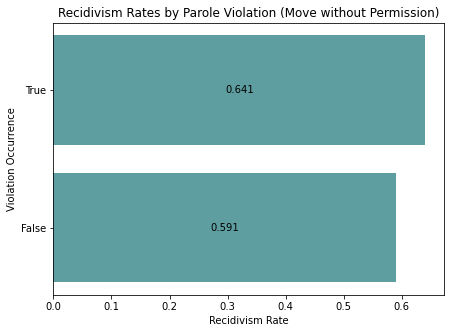

In [95]:
moving_paroleviol_recidivism = ga.groupby(by = ['violations_movewithoutpermission'])['recidivism_within_3years'].value_counts(normalize=True)
moving_paroleviol_recidivism = pd.DataFrame(moving_paroleviol_recidivism)

fig, ax = plt.subplots(figsize=(7,5))

y_vals = [val for val in moving_paroleviol_recidivism.index[0]]
recid_pcts = [round(val,3) for val in moving_paroleviol_recidivism['recidivism_within_3years']]
mwp_pv_plot = ax.barh(y=y_vals, 
    width=recid_pcts[::2], color='cadetblue')
ax.bar_label(mwp_pv_plot, label_type='center')
ax.set(title='Recidivism Rates by Parole Violation (Move without Permission)', yticks=[0, 1], yticklabels=['False', 'True'], xlabel='Recidivism Rate', ylabel='Violation Occurrence')
plt.show();

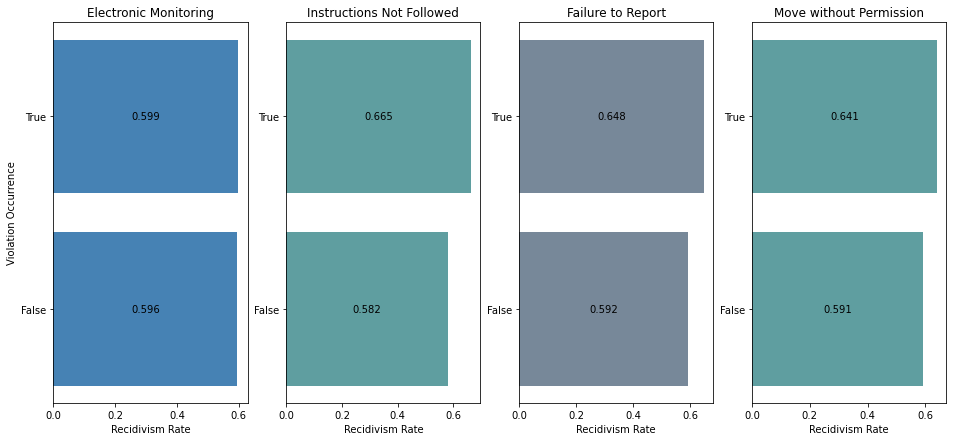

In [96]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16,7))

y_vals = [val for val in elecmonit_paroleviol_recidivism.index[0]]
recid_pcts = [round(val,3) for val in elecmonit_paroleviol_recidivism['recidivism_within_3years']]
em_pv_plot = ax1.barh(y=y_vals, 
    width=recid_pcts[::2], color='steelblue')
ax1.bar_label(em_pv_plot, label_type='center')
ax1.set(title='Electronic Monitoring', yticks=[0, 1], yticklabels=['False', 'True'], xlabel='Recidivism Rate', ylabel='Violation Occurrence')

y_vals = [val for val in instruction_paroleviol_recidivism.index[0]]
recid_pcts = [round(val,3)  for val in instruction_paroleviol_recidivism['recidivism_within_3years']]
instr_pv_plot = ax2.barh(y=y_vals, 
    width=recid_pcts[::2], color='cadetblue')
ax2.bar_label(instr_pv_plot, label_type='center')
ax2.set(title='Instructions Not Followed', yticks=[0, 1], yticklabels=['False', 'True'], xlabel='Recidivism Rate')

y_vals = [val for val in failtoreport_paroleviol_recidivism.index[0]]
recid_pcts = [round(val,3)  for val in failtoreport_paroleviol_recidivism['recidivism_within_3years']]
ftr_pv_plot = ax3.barh(y=y_vals, 
    width=recid_pcts[::2], color='lightslategrey')
ax3.bar_label(ftr_pv_plot, label_type='center')
ax3.set(title='Failure to Report', yticks=[0, 1], yticklabels=['False', 'True'], xlabel='Recidivism Rate')

y_vals = [val for val in moving_paroleviol_recidivism.index[0]]
recid_pcts = [round(val,3)  for val in moving_paroleviol_recidivism['recidivism_within_3years']]
mwp_pv_plot = ax4.barh(y=y_vals, 
    width=recid_pcts[::2], color='cadetblue')
ax4.bar_label(mwp_pv_plot, label_type='center')
ax4.set(title='Move without Permission', yticks=[0, 1], yticklabels=['False', 'True'], xlabel='Recidivism Rate')
plt.show();

While we do see a possible pattern between those who violate their parole and later end up recidivating, the connections are not necessarily strong enough to make any definitive statements. The biggest gaps in recidivism rates for parole violation occurrences are seen in the 'Instructions not Followed' and 'Failure to Report' violations. 

#### Delinquency Reports

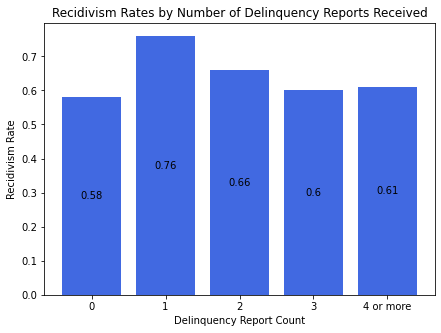

In [97]:
delinquency_recidivism = ga.groupby(by = ['delinquency_reports'])['recidivism_within_3years'].value_counts(normalize=True)
delinquency_recidivism = pd.DataFrame(delinquency_recidivism)

fig, ax = plt.subplots(figsize=(7,5))

x_vals = [val for val, bool in delinquency_recidivism.index[::2]]
recid_pcts = [round(val,2) for val in delinquency_recidivism['recidivism_within_3years'][::2]]
delinquency_plot = ax.bar(x=x_vals, 
    height=recid_pcts, color='royalblue')
ax.bar_label(delinquency_plot, label_type='center')
ax.set(title='Recidivism Rates by Number of Delinquency Reports Received', xlabel='Delinquency Report Count', ylabel='Recidivism Rate', xticks=[0,1,2,3,4], xticklabels=[0, 1, 2, 3,'4 or more'])
plt.show();

#### Residence Changes During Parole

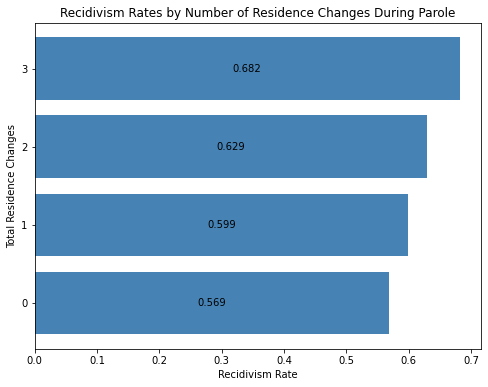

In [98]:
rsdnc_chngs_recidivism = ga.groupby(by = ['residence_changes'])['recidivism_within_3years'].value_counts(normalize=True)
rsdnc_chngs_recidivism = pd.DataFrame(rsdnc_chngs_recidivism)

fig, ax = plt.subplots(figsize = (8,6))

y_vals = [val for val, bool in rsdnc_chngs_recidivism.index[::2]]
recid_pcts = [round(val,3) for val in rsdnc_chngs_recidivism['recidivism_within_3years'][::2]]
rc_plot = ax.barh(y=y_vals, 
    width=recid_pcts, color='steelblue')
ax.bar_label(rc_plot, label_type='center')
ax.set(title='Recidivism Rates by Number of Residence Changes During Parole', xlabel='Recidivism Rate', ylabel='Total Residence Changes', yticks=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.show();

#### Conditions of Parole Release

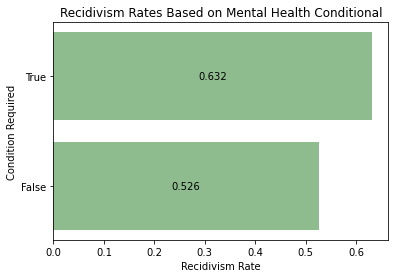

In [99]:
mentalhealth_subabuse_recidivism = ga.groupby(by = ['condition_mh_sa'])['recidivism_within_3years'].value_counts(normalize=True)
mentalhealth_subabuse_recidivism = pd.DataFrame(mentalhealth_subabuse_recidivism)

fig, ax = plt.subplots()

y_vals = [val for val in mentalhealth_subabuse_recidivism.index[0]]
recid_pcts = [round(val,3) for val in mentalhealth_subabuse_recidivism['recidivism_within_3years']]
mh_sa_plot = ax.barh(y=y_vals, 
    width=recid_pcts[::2], color='darkseagreen')
ax.bar_label(mh_sa_plot, label_type='center')
ax.set(title='Recidivism Rates Based on Mental Health Conditional', yticks=[0, 1], yticklabels=['False', 'True'], xlabel='Recidivism Rate', ylabel='Condition Required')
plt.show();

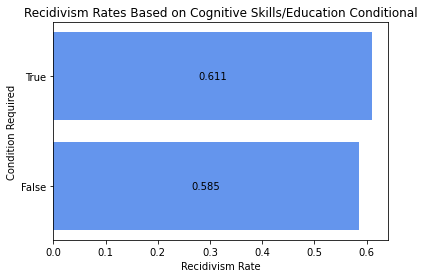

In [100]:
cog_ed_recidivism = ga.groupby(by = ['condition_cog_ed'])['recidivism_within_3years'].value_counts(normalize=True)
cog_ed_recidivism = pd.DataFrame(cog_ed_recidivism)

fig, ax = plt.subplots()

y_vals = [val for val in cog_ed_recidivism.index[0]]
recid_pcts = [round(val,3) for val in cog_ed_recidivism['recidivism_within_3years']]
cog_ed_plot = ax.barh(y=y_vals, 
    width=recid_pcts[::2], color='cornflowerblue')
ax.bar_label(cog_ed_plot, label_type='center')
ax.set(title='Recidivism Rates Based on Cognitive Skills/Education Conditional', yticks=[0, 1], yticklabels=['False', 'True'], xlabel='Recidivism Rate', ylabel='Condition Required')
plt.show();

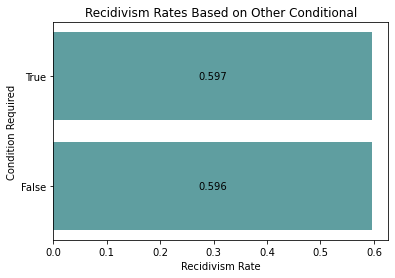

In [101]:
cond_other_recidivism = ga.groupby(by = ['condition_other'])['recidivism_within_3years'].value_counts(normalize=True)
cond_other_recidivism = pd.DataFrame(cond_other_recidivism)

fig, ax = plt.subplots()

y_vals = [val for val in cond_other_recidivism.index[0]]
recid_pcts = [round(val,3) for val in cond_other_recidivism['recidivism_within_3years']]
cond_other_plot = ax.barh(y=y_vals, 
    width=recid_pcts[::2], color='cadetblue')
ax.bar_label(cond_other_plot, label_type='center')
ax.set(title='Recidivism Rates Based on Other Conditional', yticks=[0, 1], yticklabels=['False', 'True'], xlabel='Recidivism Rate', ylabel='Condition Required')
plt.show();

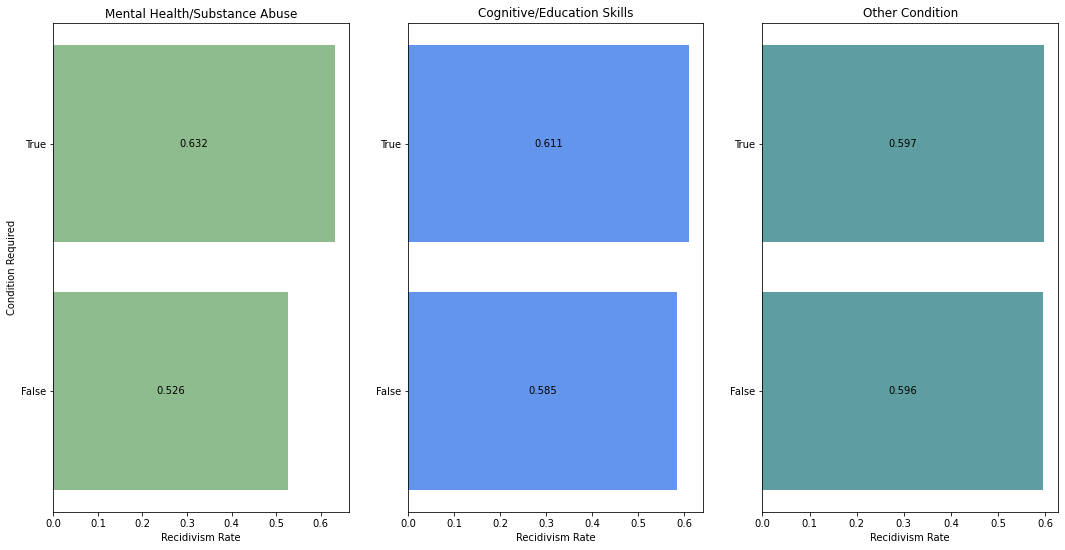

In [102]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,9))

y_vals = [val for val in mentalhealth_subabuse_recidivism.index[0]]
recid_pcts = [round(val,3) for val in mentalhealth_subabuse_recidivism['recidivism_within_3years']]
mh_sa_plot = ax1.barh(y=y_vals, 
    width=recid_pcts[::2], color='darkseagreen')
ax1.bar_label(mh_sa_plot, label_type='center')
ax1.set(title='Mental Health/Substance Abuse', yticks=[0, 1], yticklabels=['False', 'True'], xlabel='Recidivism Rate', ylabel='Condition Required')

y_vals = [val for val in cog_ed_recidivism.index[0]]
recid_pcts = [round(val,3) for val in cog_ed_recidivism['recidivism_within_3years']]
cog_ed_plot = ax2.barh(y=y_vals, 
    width=recid_pcts[::2], color='cornflowerblue')
ax2.bar_label(cog_ed_plot, label_type='center')
ax2.set(title='Cognitive/Education Skills', xlabel='Recidivism Rate', yticks=[0, 1], yticklabels=['False', 'True'])

y_vals = [val for val in cond_other_recidivism.index[0]]
recid_pcts = [round(val,3) for val in cond_other_recidivism['recidivism_within_3years']]
cond_other_plot = ax3.barh(y=y_vals, 
    width=recid_pcts[::2], color='cadetblue')
ax3.bar_label(cond_other_plot, label_type='center')
ax3.set(title='Other Condition', xlabel='Recidivism Rate', yticks=[0, 1], yticklabels=['False', 'True'])
plt.show();

### Do there appear to be any mitigating factors that decrease the likelihood of recidivism?

#### Program Attendances

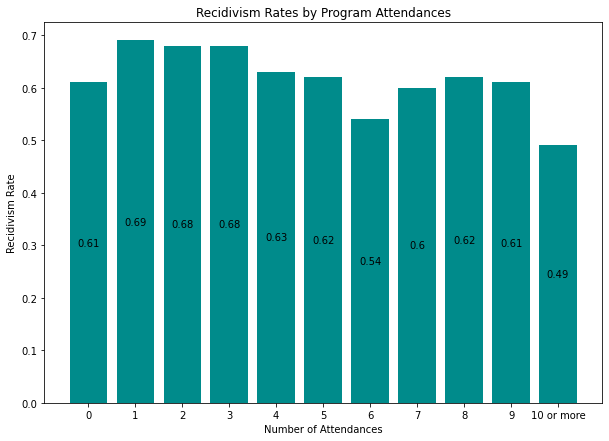

In [103]:
attendances_recidivism = ga.groupby(by = ['program_attendances'])['recidivism_within_3years'].value_counts(normalize=True)
attendances_recidivism = pd.DataFrame(attendances_recidivism)
attndnc_range = list(range(0,11))

fig, ax = plt.subplots(figsize=(10,7))

x_vals = [val for val, bool in attendances_recidivism.index[::2]]
recid_pcts = [round(val,2) for val in attendances_recidivism['recidivism_within_3years'][:-2][::2]]
recid_pcts.append(round(attendances_recidivism['recidivism_within_3years'][10][1],2))
attendance_plot = ax.bar(x=x_vals, 
    height=recid_pcts, color='darkcyan')
ax.bar_label(attendance_plot, label_type='center')
ax.set(title='Recidivism Rates by Program Attendances', xlabel='Number of Attendances', ylabel='Recidivism Rate', xticks=attndnc_range, xticklabels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, '10 or more'])
plt.show();

#### Employment During Parole

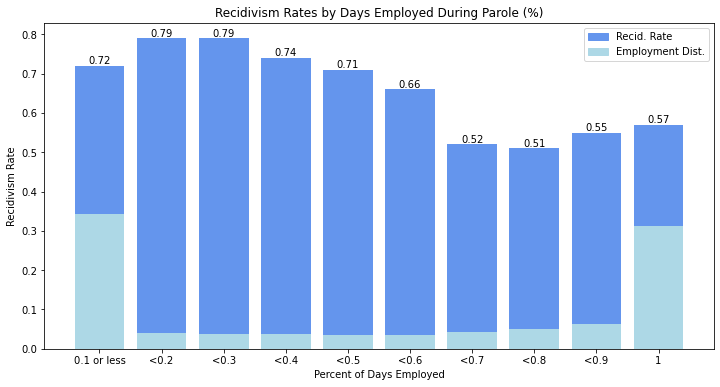

In [104]:
# Adding a column here to categorize the individual values within the pct_days_employed column

ga['pct_days_employed_categ'] = pd.cut(ga['percent_days_employed'], bins=10, labels=['0.1 or less', '<0.2', '<0.3', '<0.4', '<0.5', '<0.6', '<0.7', '<0.8', '<0.9', '1'])

employed_recidivism = ga.groupby(by = ['pct_days_employed_categ'])['recidivism_within_3years'].value_counts(normalize=True)
employed_recidivism = pd.DataFrame(employed_recidivism)

fig, ax = plt.subplots(figsize=(12,6))

x_vals = [val for val, bool in employed_recidivism.index[::2]]
recid_pcts = [round(val,2) for val in employed_recidivism['recidivism_within_3years'][::2]]
emp_plot = ax.bar(x=x_vals, height=recid_pcts, color='cornflowerblue')
ax.bar(height= ga['pct_days_employed_categ'].value_counts(normalize=True).sort_index(axis=0), x=x_vals, color='lightblue')
ax.bar_label(emp_plot, label_type='edge')
ax.set(title='Recidivism Rates by Days Employed During Parole (%)', xlabel='Percent of Days Employed', ylabel='Recidivism Rate')
recid_rates = mpatches.Patch(color='cornflowerblue', label='Recid. Rate')
days_emp_pcts = mpatches.Patch(color='lightblue', label='Employment Dist.')
plt.legend(handles=[recid_rates, days_emp_pcts])
plt.show();

#### Drug Test Frequency

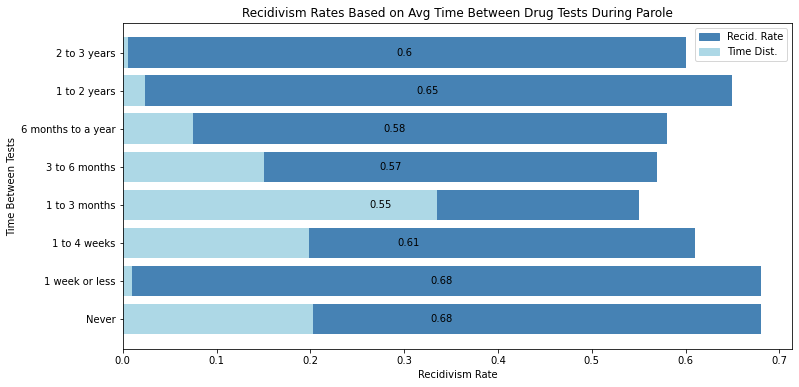

In [105]:
# Similar to pct_days_employed and prior_arrests, adding a column here so that we're able to categorize the coontinuous values in the avg_days_per_drugtest column

ga['avg_days_per_drugtest_categ'] = pd.cut(ga['avg_days_per_drugtest'], bins=[0, 1, 7, 30, 90, 180, 365, 730, 1095], right=True, labels=['Never', '1 week or less', '1 to 4 weeks', '1 to 3 months', '3 to 6 months', '6 months to a year', '1 to 2 years', '2 to 3 years'], include_lowest=True)

avg_days_drugtest_recidivism = ga.groupby(by = ['avg_days_per_drugtest_categ'])['recidivism_within_3years'].value_counts(normalize=True)
avg_days_drugtest_recidivism = pd.DataFrame(avg_days_drugtest_recidivism)

fig, ax = plt.subplots(figsize=(12,6))

y_vals = [val for val, bool in avg_days_drugtest_recidivism.index[::2]]
recid_pcts = [round(val,2) for val in avg_days_drugtest_recidivism['recidivism_within_3years'][::2]]
avg_days__plot = ax.barh(y=y_vals, width=recid_pcts, color='steelblue')
ax.barh(width= ga['avg_days_per_drugtest_categ'].value_counts(normalize=True).sort_index(axis=0), y=y_vals, color='lightblue')
ax.bar_label(avg_days__plot, label_type='center')
ax.set(title='Recidivism Rates Based on Avg Time Between Drug Tests During Parole', xlabel='Recidivism Rate', ylabel='Time Between Tests')
recid_rates = mpatches.Patch(color='steelblue', label='Recid. Rate')
days_btwn_pcts = mpatches.Patch(color='lightblue', label='Time Dist.')
plt.legend(handles=[recid_rates, days_btwn_pcts])
plt.show();

**Combined/Summary Visualizations**

**FINAL NOTES:**
- All visualizations from this EDA exercise can be found in the **visualizations** directory.
- There is no data output from this notebook.
- The next notebook in the series is [Modeling](./03_modeling.ipynb).